# Human Activity Recognition for Healthy Lifestyle Monitoring

Group 40: Alvaro Menéndez Ros, Juan José Leguineche Gállego, Pablo Herrero Ortiz

This project implements a **Human Activity Recognition system** using smartphone sensor data to classify five core daily activities: sitting down, standing up, walking, running, and climbing stairs. The solution follows a complete pipeline, including:

1. **Data Acquisition**: Collecting raw accelerometer, gravitational and gyroscope signals from smartphones during different activities.  
2. **Preprocessing**: Cleaning and segmenting noisy time-series data into structured windows.  
3. **Feature Extraction**: Deriving meaningful statistical and frequency-based features that capture movement patterns.  
4. **Model Development**: Training supervised machine learning models to distinguish between activities.  
5. **Evaluation**: Assessing model performance using accuracy, precision, recall, and confusion matrices to ensure robustness.  

By simulating real-world challenges in digital health, the system demonstrates how wearable sensor data can be transformed into actionable insights for **health monitoring and activity tracking applications**.  


## Config Variables

In [22]:
CSV_DATA_PATH="../data/merged_data.csv"
PROCESSED_DATA_DIR = "../data/"
OUTPUT_FILE = '../data/merged_data.csv'

# TESTING MODEL W/NEW DATA
TEST_CSV_DATA_PATH = "../test_data/merged_data.csv"
TEST_PROCESSED_DATA_DIR = "../test_data/"
TEST_OUTPUT_FILE = '../test_data/merged_data.csv'

# 2 seconds window size
WINDOW_SIZE=200
STEP=50
TEST_SIZE=0.2

# Column definitions
SENSOR_COLUMNS = {
    'time': 'seconds_elapsed',
    'gyroscope': ['gyro_x', 'gyro_y', 'gyro_z'],
    'accelerometer': ['acc_x', 'acc_y', 'acc_z'],
    'gravity': ['grav_x', 'grav_y', 'grav_z']
}

LABEL_COLUMN = 'label'

FEATURE_COLUMNS = (
    [SENSOR_COLUMNS['time']] +
    SENSOR_COLUMNS['gyroscope'] +
    SENSOR_COLUMNS['accelerometer'] +
    SENSOR_COLUMNS['gravity']
)


ALL_REQUIRED_COLUMNS = FEATURE_COLUMNS + [LABEL_COLUMN]

## Helper Functions

In [16]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, class_names=None, output_path=None):
    """
    Compact confusion matrix plot with larger numbers - text only on left side
    """
    if class_names is None:
        class_names = [f"Class {i}" for i in range(cm.shape[0])]
    
    # Create a more compact figure
    fig_size = max(4, len(class_names) * 0.8)  # Dynamic sizing based on number of classes
    plt.figure(figsize=(fig_size, fig_size * 0.9))
    
    # Create heatmap with larger annotations
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names, yticklabels=class_names,
                    annot_kws={'size': 14, 'weight': 'bold'},  # Bigger, bolder numbers
                    cbar=False,  # Remove colorbar to save space
                    square=True)  # Make cells square for better proportions
    
    # Adjust font sizes for labels
    plt.xlabel('Predicted', fontsize=12, fontweight='bold')
    plt.ylabel('True', fontsize=12, fontweight='bold')
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    
    # Remove bottom tick labels
    plt.xticks([])  # Remove x-axis tick labels (bottom)
    plt.yticks(fontsize=10, rotation=0)  # Keep y-axis labels horizontal
    
    # Move the "True" label to the right side
    ax.yaxis.set_label_position("right")
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
    plt.show()
    
    # Print summary stats
    total = np.sum(cm)
    accuracy = np.trace(cm) / total if total > 0 else 0
    print(f"Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")

def get_accuracy(confusion_matrix):
    """Calculates the accuracy from a confusion matrix."""
    return np.trace(confusion_matrix) / np.sum(confusion_matrix)

def check_best(pipeline, confusion_matrix, model_path):
    """Checks if its the best performing model and saves"""
    if model_path:
        cm_path = f"results/{model_path.split('/')[-1].replace('.joblib', '.png')}"
        plot_confusion_matrix(confusion_matrix, pipeline.labels, output_path=cm_path)
    else:
        plot_confusion_matrix(confusion_matrix, pipeline.labels)

## Data Loader
Utility class to load and preprocess the dataset from a CSV file.

### Usage
1. Instantiate the DataLoader class with the path to the CSV file:    
2. Call the get_data() method to preprocess the data and return the train-test split
```python
data_loader = DataLoader(data_path)
X_train, X_test, y_train, y_test = data_loader.get_data()
```

### How it Works
- Reads CSV using `Pandas`
- Divides classes data into train and test sets (80% train, 20% test).
- The division of data is performed **before** creating the windows to avoid data leakage.
![Data Splitting](../images/drawio/img/data_splitting.drawio.png)
- Creates windows of data with a specified **window_size=200** and **step_size=50** (2 second samples with 0.5 second overlap)

### Dashboard
In order to ensure the correct dataset creation, a dataset viewer dashboard was created.
Run the following command to start the dashboard:
```bash
python -m streamlit run src/visualizers/dataset_visualizer.py
```
<img src="../images/dataset_viewer.jpeg" width="50%" height="auto">


In [17]:
import pandas as pd
import numpy as np
import os

class DataLoader:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None
        
    def load_data(self):
        """Loads the dataset from the specified CSV file path."""
        if self.data is not None:
            return

        try:
            abs_path = os.path.abspath(self.file_path)
            print(f"Trying to load file from: {abs_path}")
            
            # Load only the required columns
            self.data = pd.read_csv(abs_path, usecols=ALL_REQUIRED_COLUMNS)
            print("File loaded successfully with required features.")
        except FileNotFoundError:
            print(f"File not found: {abs_path}")
            self.data = pd.DataFrame() # Ensure self.data is not None


    # OPTIMIZED
    def _create_windows(self, df, window_size, step):
        """
        Helper function to create time-series windows from a dataframe.
        :returns: num_windows, window_size, num_features
        """
        # Check if dataframe is empty or too small for windowing
        if len(df) < window_size:
            print(f"Warning: Dataset has {len(df)} rows, which is less than window_size {window_size}")
            return np.array([]), np.array([])
        
        # Pre-compute feature columns to avoid repeated drop operations
        feature_df = df.drop(LABEL_COLUMN, axis=1)
        feature_values = feature_df.values
        label_values = df[LABEL_COLUMN].values
        
        # Calculate number of windows to pre-allocate arrays
        num_windows = max(0, (len(df) - window_size) // step + 1)
        num_features = len(feature_df.columns)
        
        # Pre-allocate arrays for better memory efficiency
        X = np.empty((num_windows, window_size, num_features), dtype=np.float64)
        y = np.empty(num_windows, dtype=object)
        
        # Process windows in chunks to avoid memory issues
        chunk_size = 1000  # Process 1000 windows at a time
        window_idx = 0
        
        for chunk_start in range(0, len(df) - window_size, chunk_size * step):
            chunk_end = min(chunk_start + chunk_size * step, len(df) - window_size)
            
            for i in range(chunk_start, chunk_end, step):
                if window_idx >= num_windows:
                    break
                    
                # Extract window features more efficiently
                X[window_idx] = feature_values[i:i + window_size]
                
                # Get the most common label in the window
                window_labels = label_values[i:i + window_size]
                unique_labels, counts = np.unique(window_labels, return_counts=True)
                y[window_idx] = unique_labels[np.argmax(counts)]
                
                window_idx += 1
                
            if window_idx >= num_windows:
                break
        
        # Trim arrays to actual size
        X = X[:window_idx]
        y = y[:window_idx]
        
        return X, y

    def get_data(self, test_size=TEST_SIZE, window_size=WINDOW_SIZE, step=STEP):
        """
        Processes the loaded data to create non-leaky training and test sets
        with moving windows.

        Args:
            test_size (float): The proportion of the dataset to allocate to the test split for each activity.
            window_size (int): The number of timesteps in one window (e.g., 20 steps = 2 seconds if 0.1s interval).
            step (int): The number of timesteps to slide the window forward.
        
        Returns:
            tuple: A tuple containing X_train, X_test, y_train, y_test, and a list of unique labels.
        """
        if test_size is None:
            test_size = TEST_SIZE

        self.load_data()
        if self.data is None or self.data.empty:
            print("Data not loaded. Cannot process.")
            return None, None, None, None, [], []

        labels = self.data[LABEL_COLUMN].unique()
        feature_names = FEATURE_COLUMNS
        
        train_dfs = []
        test_dfs = []

        # --- Step 1: Temporal Split ---
        print("\nPerforming temporal split for each activity...")
        for label in labels:
            activity_df = self.data[self.data[LABEL_COLUMN] == label].copy()
            split_index = int(len(activity_df) * (1 - test_size))
            activity_train = activity_df.iloc[:split_index]
            activity_test = activity_df.iloc[split_index:]
            train_dfs.append(activity_train)
            test_dfs.append(activity_test)

        train_df = pd.concat(train_dfs).reset_index(drop=True)
        test_df = pd.concat(test_dfs).reset_index(drop=True)
        
        print(f"Training Set Shape (before windowing): {train_df.shape}")
        print(f"Test Set Shape (before windowing): {test_df.shape}")

        # --- Step 2: Create Moving Windows ---
        print("\nCreating moving windows for training and test sets...")
        X_train, y_train = self._create_windows(train_df, window_size, step)
        X_test, y_test = self._create_windows(test_df, window_size, step)
        print("Windowing complete")
        print(f"Training Set Shape (after windowing): {X_train.shape}")
        print(f"Test Set Shape (after windowing): {X_test.shape}")

        return X_train, X_test, y_train, y_test, labels, feature_names


## Abstract Base Model
This allows to easily create and compare different ML models.
A base model class is defined with the following main methods:
```python
    @abstractmethod
    def fit(self, X, y, labels):
        pass 

    @abstractmethod
    def predict(self, X):
        pass 


In [18]:
import numpy as np
from abc import ABC, abstractmethod # abstract base class
import joblib # save the models

class BaseModel(ABC):
    """
    Abstract Base Class for all machine learning models.
    """
    
    def __init__(self):
        self._model = None 
        print(f"Initialized an instance of {self.__class__.__name__}")

    @abstractmethod
    def fit(self, X, y, labels):
        pass 

    @abstractmethod
    def predict(self, X):
        pass 

    def save(self, file_path: str):
        if self._model is not None:
            joblib.dump(self._model, file_path)
            print(f"Model saved successfully to {file_path}")
        else:
            raise ValueError("Model has not been trained yet. Call .fit() before saving.")

    @classmethod
    def load(cls, file_path: str):
        instance = cls() # Create a new instance of the class
        instance._model = joblib.load(file_path)
        print(f"Model loaded successfully from {file_path}")
        return instance

### Random Forest implementation
Simple Random Forest implementation with default parameters:
- Flattens the input data to 2D (samples, timesteps * features)

In [19]:
from sklearn.ensemble import RandomForestClassifier

class RandomForest(BaseModel):
    """
    A simple baseline model using RandomForestClassifier.
    It flattens the windowed input data to make it compatible.
    """
    def __init__(self, **kwargs):
        super().__init__()
        # Store model hyperparameters, e.g., n_estimators=100
        self.kwargs = kwargs

    def fit(self, X, y, labels=None):
        """
        Trains the RandomForest model.
        
        It reshapes the 3D input X (samples, timesteps, features)
        into a 2D array (samples, timesteps * features).
        """
        print("Fitting RandomForest...")
        
        # 1. Reshape the data
        n_samples = X.shape[0]
        # Flatten the (window_size, features) into a single dimension
        X_reshaped = X.reshape(n_samples, -1)
        
        print(f"Original X shape: {X.shape}")
        print(f"Reshaped X shape for RandomForest: {X_reshaped.shape}")

        # 2. Initialize and train the model
        # We create the model instance here, inside fit()
        self._model = RandomForestClassifier(random_state=42, **self.kwargs)
        print("Training model...")
        self._model.fit(X_reshaped, y)
        
        print("Model training complete.")
        return self

    def predict(self, X):
        """
        Makes predictions using the trained model.

        It reshapes the 3D input X in the same way as the fit method.
        """
        if self._model is None:
            raise NotFittedError("Model has not been trained yet. Call .fit() before making predictions.")
        
        # 1. Reshape the data exactly as done in the .fit() method
        n_samples = X.shape[0]
        X_reshaped = X.reshape(n_samples, -1)

        # 2. Make predictions
        predictions = self._model.predict(X_reshaped)
        return predictions

## Full Pipeline

In [20]:
from sklearn.metrics import confusion_matrix
from datetime import datetime
import os


class Pipeline():
    def __init__(self, data_loader, model):
        self.data_loader = data_loader
        self.model = model
        self.labels = None
        self.best_accuracy = self.load_best_accuracy()

    def load_best_accuracy(self):
        if not os.path.exists("results"):
            os.makedirs("results")
        try:
            with open('results/best_accuracy.txt', 'r') as f:
                return float(f.read())
        except (FileNotFoundError, ValueError):
            return 0.0

    def save_best_accuracy(self):
        with open('results/best_accuracy.txt', 'w') as f:
            f.write(str(self.best_accuracy))

    def run_pipeline(self, model_path=None, test_size=None, force_save=False):
        X_train, X_test, y_train, y_test, labels, _ = self.data_loader.get_data(test_size=test_size)
        self.labels = labels
        if model_path:
            print(f"Loading model from {model_path}")
            self.model = self.model.load(model_path)
        else:
            print("Fitting new model...")
            self.model = self.model.fit(X_train, y_train, labels)
        predictions = self.model.predict(X_test)
        cm = confusion_matrix(y_test, predictions)
        accuracy = get_accuracy(cm)
        model_path = None
        if accuracy > self.best_accuracy or force_save:
            if accuracy > self.best_accuracy:
                self.best_accuracy = accuracy
                self.save_best_accuracy()
            date_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            model_path = f"models/{self.model.__class__.__name__}_{date_str}.joblib"
            # Create models directory if it doesn't exist
            os.makedirs("models", exist_ok=True)
            self.model.save(model_path)
        return cm, model_path



## Main Entrypoint

Initialized an instance of RandomForest
Trying to load file from: c:\Users\Alvaro\Documents\GitHub\Human-Activity-Recognition_UsingML\data\merged_data.csv


File loaded successfully with required features.

Performing temporal split for each activity...
Training Set Shape (before windowing): (29245, 11)
Test Set Shape (before windowing): (7314, 11)

Creating moving windows for training and test sets...
Windowing complete
Training Set Shape (after windowing): (581, 200, 10)
Test Set Shape (after windowing): (143, 200, 10)
Fitting new model...
Fitting RandomForest...
Original X shape: (581, 200, 10)
Reshaped X shape for RandomForest: (581, 2000)
Training model...
Model training complete.
Model saved successfully to models/RandomForest_2025-10-03_11-55-06.joblib


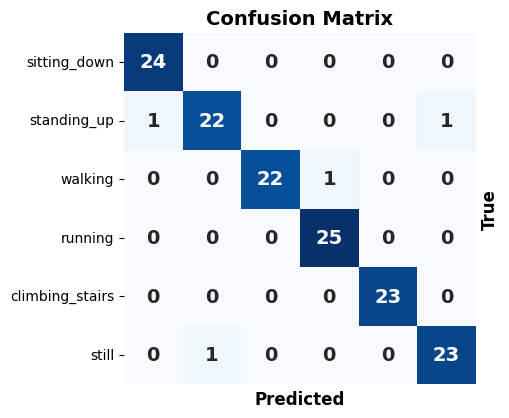

Accuracy: 0.972 (97.2%)


In [21]:
data_path = CSV_DATA_PATH
model_path = None
save_model = True

data_loader = DataLoader(data_path)
model = RandomForest()
pipeline = Pipeline(data_loader, model)
confusion_matrix, model_path = pipeline.run_pipeline(model_path, test_size=TEST_SIZE, force_save=save_model)
check_best(pipeline, confusion_matrix, model_path)
